# Project 242

## Import

In [707]:
from backtester.backtesting import Strategy
from modules.data_preprocessing import *
from modules.add_features import *
from modules.metrics_prediction import *
from modules.metrics_performance import *
from modules.models import *
from modules.utils import *

In [708]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd

## I. Data

### 1. Load data

In [709]:
data = pd.read_csv('data/Binance_BTCUSDT_1h.csv')

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,1.637280e+12,2021-11-19 00:00:00,BTC/USDT,56891.62,57247.58,56674.00,57144.98,719.65701,4.099574e+07,19977.0
1,1.637276e+12,2021-11-18 23:00:00,BTC/USDT,56613.30,56987.57,56474.26,56891.62,2553.36240,1.447890e+08,76763.0


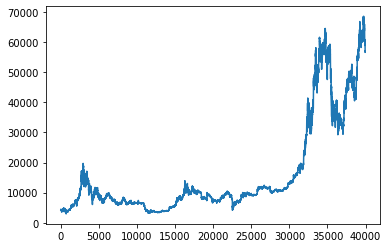

In [710]:
plt.plot(data[::-1].reset_index().close)
data.head(2)

### 2. Preprocess data

- clean data
- add features

In [711]:
# Clean data
data = clean_data(data)
data = data.rename(columns = {'Volume USDT': 'Volume'})

Here, we can decide to add features ...

In [712]:
# Add features

data = add_technical_indicators(data, lookback_period=30)[30:]

In [713]:
data.head()

,open,high,low,close,Volume,MOM,RSI,VWAP,BB_high,BB_low,EMA,CCI,MACD
30,4304.15,4371.52,4296.04,4356.31,223471.00,-29.750833,53.271105,4317.294208,4462.289132,4215.078202,4318.454360,13.166937,-29.750833
31,4356.31,4357.37,4302.72,4340.31,104474.98,-20.882000,51.723613,4317.656777,4462.817545,4216.215788,4319.864401,1.766283,-20.882000
32,4340.31,4340.31,4287.79,4336.52,65468.18,-15.141667,51.358028,4317.653726,4463.100965,4216.743702,4320.938956,-14.054429,-15.141667
33,4331.71,4331.71,4221.05,4261.99,72942.01,-16.511000,44.901817,4317.082533,4463.222261,4210.755739,4317.135797,-76.273927,-16.511000
34,4293.09,4293.09,4193.70,4259.40,302601.43,-23.350333,44.699809,4313.908193,4462.519661,4204.705672,4313.410907,-99.718186,-23.350333


In [714]:
data.loc[data['VWAP'].isna(), 'VWAP'] = 0

In [715]:
# Split data
train_data, test_data = split_data(data, split=0.25)

train_data = array_to_df(train_data, data.columns)
test_data = array_to_df(test_data, data.columns)

print(f'Shape X_train: {train_data.shape} | X_test: {test_data.shape}')

Shape X_train: (29936, 13) | X_test: (9978, 13)


In [716]:
# Scale data
#train_data, test_data = scale_data(train_data, test_data)

In [717]:
# Add Return
train_data = add_return(train_data)
test_data = add_return(test_data)

In [718]:
# Add Signal
q_90 = np.quantile(abs(train_data.Return).iloc[:-1].values, 0.9)

train_data = add_signal(train_data, q_90)
test_data = add_signal(test_data, q_90)

In [719]:
train_pos, train_neg = round((train_data.Signal>0).sum()/train_data.Signal.shape[0],2)*100, round((train_data.Signal<0).sum()/train_data.Signal.shape[0],2)*100
test_pos, test_neg = round((test_data.Signal>0).sum()/test_data.Signal.shape[0],2)*100, round((test_data.Signal<0).sum()/test_data.Signal.shape[0],2)*100

print(f'Train set: 1 ({train_pos}%) | 0 ({100-(train_pos+train_neg)}%) | -1 ({train_neg}%)') 
print(f'Test set: 1 ({test_pos}%) | 0 ({100-(test_pos+test_neg)}%) | -1 ({test_neg}%)') 

Train set: 1 (5.0%) | 0 (90.0%) | -1 (5.0%)
Test set: 1 (6.0%) | 0 (88.0%) | -1 (6.0%)


In [720]:
#display(train_data.head(2))
#display(test_data.head(2))

## II. Model

### 1. Get data ready for models

In this section, the reformating of the data may depend on the model ...

In [721]:
train = prepare_data_2D_format(train_data)
train.head()

/Users/noemielevy/INDENG-242-project/modules/data_preprocessing.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(X), S, R


,open_day_minus10,high_day_minus10,low_day_minus10,close_day_minus10,Volume_day_minus10,MOM_day_minus10,RSI_day_minus10,VWAP_day_minus10,BB_high_day_minus10,BB_low_day_minus10,...,Volume_day_minus1,MOM_day_minus1,RSI_day_minus1,VWAP_day_minus1,BB_high_day_minus1,BB_low_day_minus1,EMA_day_minus1,CCI_day_minus1,MACD_day_minus1,Signal
0,4077.00,4082.00,3986.87,3986.87,201920.41,-92.501000,36.313482,4220.358775,4413.638948,3987.591052,...,32834.24,-103.921167,40.741816,4144.091600,4348.360954,3895.303046,4107.695434,-85.948662,-103.921167,-1
1,3957.60,4095.00,3928.89,4095.00,89392.01,-136.101833,45.462478,4174.809801,4385.457615,3913.728385,...,16200.70,-3.944333,46.000835,4092.043782,4212.744375,3934.157625,4091.762120,32.104436,-3.944333,-1
2,4027.37,4096.00,4013.69,4086.29,68501.09,-64.022500,46.506902,4118.017956,4267.405873,3914.959460,...,1428.52,32.074000,47.378393,4064.234571,4184.421338,3960.727995,4097.724160,52.987962,32.074000,-1
3,4076.12,4103.92,4051.47,4075.98,12154.59,-29.977000,46.077881,4100.184733,4230.023958,3927.722042,...,44122.84,27.114333,48.600176,4060.554893,4183.700372,3960.668295,4098.709093,67.056595,27.114333,-1
4,4086.09,4086.09,4052.82,4082.53,4322.96,39.186667,46.629637,4060.730489,4181.206779,3949.108554,...,3915.52,59.559833,49.842529,4035.342131,4190.674524,3958.907476,4113.626898,99.555525,59.559833,-1


In [722]:
X_train, y_train, return_train = prepare_data_for_training(train_data, lookback_period=10, signal = True)
X_test, y_test, return_test = prepare_data_for_training(test_data, lookback_period=10, signal = True)

y_train = y_train[10:]

/Users/noemielevy/INDENG-242-project/modules/data_preprocessing.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(X), S, R


In [723]:
## Remove empty lists in the beginning
while len(X_train[0]) == 0:
    X_train = X_train[1:]
    y_train = y_train[1:]
    
while len(X_test[0]) == 0:
    X_test = X_test[1:]
    y_test = y_test[1:]

In [724]:
from tqdm import tqdm
def format_2D(arr):
    res = []
    for item in arr:
        features = []
        for day in item:
            features += day.tolist()
        res.append(features)
    return res
X_train = format_2D(X_train)
X_test = format_2D(X_test)

In [725]:
## Some indicators have a larger lookback period than other. 
## We remove the beginning of the dataset to make everything homogeneous

while len(X_train[0]) != 10*len(data.columns):
    X_train = X_train[1:]
    y_train = y_train[1:]
    
while len(X_test[0]) != 10*len(data.columns):
    X_test = X_test[1:]
    y_test = y_test[1:]
    
X_train = np.array(X_train)
X_test = np.array(X_test)

### 2. Build model

The ultimate goal of this section is to return a **prediction**.

This section may recquire a phase of **feature selection**.

...

In [726]:
features = []
for k in range(10):
    features = features + [col+"_day_minus"+str(10-k) for col in data.columns]

In [727]:
train = pd.DataFrame(X_train)
train.columns = features
train['Signal'] = pd.Series(y_train)

test = pd.DataFrame(X_test)
test.columns = features
test['Signal'] = pd.Series(y_test)

In [728]:
str_formula = 'Signal ~ '
for feat in features:
    str_formula += feat + ' + '
str_formula = str_formula[:-3]

In [729]:
import statsmodels.formula.api as smf
import numpy as np

# at first I will use all features
# fitting data to the model
reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.797
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           1.22e-20
Time:                        21:03:38   Log-Likelihood:                -7788.4
No. Observations:               29896   AIC:                         1.580e+04
Df Residuals:                   29784   BIC:                         1.673e+04
Df Model:                         111                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0113    

We perform feature selection using the p-value

In [730]:
## remove high_day_minus4:
removed = ['high_day_minus4']
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.823
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           7.24e-21
Time:                        21:03:40   Log-Likelihood:                -7788.4
No. Observations:               29896   AIC:                         1.580e+04
Df Residuals:                   29785   BIC:                         1.672e+04
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0113    

In [731]:
## remove Volume_day_minus2:
removed = ['high_day_minus4', 'Volume_day_minus2']
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.849
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           4.27e-21
Time:                        21:03:43   Log-Likelihood:                -7788.4
No. Observations:               29896   AIC:                         1.580e+04
Df Residuals:                   29786   BIC:                         1.671e+04
Df Model:                         109                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0113    

In [732]:
## remove Volume_day_minus8:
removed = ['high_day_minus4', 'Volume_day_minus2', 'Volume_day_minus8']
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.875
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           2.50e-21
Time:                        21:03:45   Log-Likelihood:                -7788.4
No. Observations:               29896   AIC:                         1.579e+04
Df Residuals:                   29787   BIC:                         1.670e+04
Df Model:                         108                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0113    

In [733]:
## remove MOM_day_minus6:
removed.append('MOM_day_minus6')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.875
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           2.50e-21
Time:                        21:03:46   Log-Likelihood:                -7788.4
No. Observations:               29896   AIC:                         1.579e+04
Df Residuals:                   29787   BIC:                         1.670e+04
Df Model:                         108                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0113    

In [734]:
## remove MACD_day_minus6:
removed.append('MACD_day_minus6')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.902
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           1.46e-21
Time:                        21:03:48   Log-Likelihood:                -7788.4
No. Observations:               29896   AIC:                         1.579e+04
Df Residuals:                   29788   BIC:                         1.669e+04
Df Model:                         107                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0113    

In [735]:
## remove high_day_minus3:
removed.append('high_day_minus3')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.929
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           8.54e-22
Time:                        21:03:50   Log-Likelihood:                -7788.4
No. Observations:               29896   AIC:                         1.579e+04
Df Residuals:                   29789   BIC:                         1.668e+04
Df Model:                         106                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0113    

In [736]:
## remove close_day_minus3:
removed.append('close_day_minus3')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.929
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           8.54e-22
Time:                        21:03:52   Log-Likelihood:                -7788.4
No. Observations:               29896   AIC:                         1.579e+04
Df Residuals:                   29789   BIC:                         1.668e+04
Df Model:                         106                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0113    

In [737]:
## remove EMA_day_minus10
removed.append('EMA_day_minus10')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.929
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           8.54e-22
Time:                        21:03:54   Log-Likelihood:                -7788.4
No. Observations:               29896   AIC:                         1.579e+04
Df Residuals:                   29789   BIC:                         1.668e+04
Df Model:                         106                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0113    

In [738]:
## remove EMA_day_minus9:
removed.append('EMA_day_minus9')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.929
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           8.54e-22
Time:                        21:03:55   Log-Likelihood:                -7788.4
No. Observations:               29896   AIC:                         1.579e+04
Df Residuals:                   29789   BIC:                         1.668e+04
Df Model:                         106                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0113    

In [739]:
## remove all EMAs
## EMAs are computed in a recurrent way, which is why they are so highly correlated
removed.append('EMA_day_minus8')
removed.append('EMA_day_minus7')
removed.append('EMA_day_minus6')
removed.append('EMA_day_minus5')
removed.append('EMA_day_minus4')
removed.append('EMA_day_minus3')
removed.append('EMA_day_minus2')
removed.append('EMA_day_minus1')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.985
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           2.88e-22
Time:                        21:03:57   Log-Likelihood:                -7788.4
No. Observations:               29896   AIC:                         1.579e+04
Df Residuals:                   29791   BIC:                         1.666e+04
Df Model:                         104                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0133    

In [740]:
## remove close_day_minus5
removed.append('close_day_minus5')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     3.014
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           1.65e-22
Time:                        21:03:59   Log-Likelihood:                -7788.4
No. Observations:               29896   AIC:                         1.578e+04
Df Residuals:                   29792   BIC:                         1.665e+04
Df Model:                         103                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0133    

In [741]:
## remove RSI_day_minus5
removed.append('RSI_day_minus5')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     3.042
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           1.01e-22
Time:                        21:04:01   Log-Likelihood:                -7788.6
No. Observations:               29896   AIC:                         1.578e+04
Df Residuals:                   29793   BIC:                         1.664e+04
Df Model:                         102                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0133    

In [742]:
## remove RSI_day_minus1
removed.append('RSI_day_minus1')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     3.070
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           6.09e-23
Time:                        21:04:02   Log-Likelihood:                -7788.6
No. Observations:               29896   AIC:                         1.578e+04
Df Residuals:                   29794   BIC:                         1.663e+04
Df Model:                         101                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0118    

In [743]:
## remove high_day_minus2
removed.append('high_day_minus2')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     3.101
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           3.46e-23
Time:                        21:04:04   Log-Likelihood:                -7788.7
No. Observations:               29896   AIC:                         1.578e+04
Df Residuals:                   29795   BIC:                         1.662e+04
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0117    

In [744]:
## remove CCI_day_minus1
removed.append('CCI_day_minus1')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     3.130
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           2.09e-23
Time:                        21:04:05   Log-Likelihood:                -7788.8
No. Observations:               29896   AIC:                         1.578e+04
Df Residuals:                   29796   BIC:                         1.661e+04
Df Model:                          99                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0114    

In [745]:
## remove BB_low_day_minus3
removed.append('BB_low_day_minus3')
str_formula = 'Signal ~ '
for feat in features:
    if feat not in removed: str_formula += feat + ' + '
str_formula = str_formula[:-3]

reg = smf.ols(formula  = str_formula, data = train).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Signal   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     3.162
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           1.18e-23
Time:                        21:04:08   Log-Likelihood:                -7788.8
No. Observations:               29896   AIC:                         1.578e+04
Df Residuals:                   29797   BIC:                         1.660e+04
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0115    

In [746]:
y_prob = reg.predict(test)

p75 = y_prob.mean() + y_prob.std()/3
p25 = y_prob.mean() - y_prob.std()/3
def classifier(x):
    ''' Use the distribution of y_prob to define the classifier'''
    if x < p25: return -1
    if x > p75: return 1
    return 0
y_pred = [classifier(x) for x in y_prob]
freq = {'1': len([x for x in y_pred if x == 1]), 
        '-1': len([x for x in y_pred if x == -1]), 
        '0': len([x for x in y_pred if x == 0])}
print(freq)

{'1': 3006, '-1': 3209, '0': 3753}


### 3. Test prediction model

In [747]:
TPR, FPR = 0, 0#get_TPR_FPR(y_test, y_pred)
F1 = 0#get_F1(y_test, y_pred)
ACC = get_ACC(y_test, y_pred)
WACC = 0#get_WACC(y_test, y_pred, test_data.close)

In [748]:
models = ['Baseline']
metrics = ['TPR', 'FPR', 'ACC', 'F1', 'WACC']
metric_data = [[TPR, FPR, ACC, F1, WACC]]

pd.DataFrame(metric_data, index=models, columns=metrics)

,TPR,FPR,ACC,F1,WACC
Baseline,0,0,0.382725,0,0


### III. Strategy

### 1. Get data ready for backtesting

In [749]:
# If the model used is a regression model on the return
#signal = get_signal(y_pred, alpha=q_90)

In [750]:
signal = pd.Series(y_pred)
close = test_data.close
signal.describe()

count    9968.000000
mean       -0.020365
std         0.789394
min        -1.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         1.000000
dtype: float64

In [751]:
# Crop for better visualization
nb_days = 1

signal_crop = crop_window(signal, nb_days)
close_crop = crop_window(close, nb_days)

### 2. Backtesting

In [752]:
strat = Strategy(cash=500, fees=0.001)

In [753]:
strat.run(signal_crop, close_crop, verbose=False)

In [754]:
wallet = np.array(strat.wallet)
profit_list = [0]
for i in range(1, len(wallet)):
    profit_list.append(wallet[i]-wallet[i-1])
    
profit = np.array(profit_list)

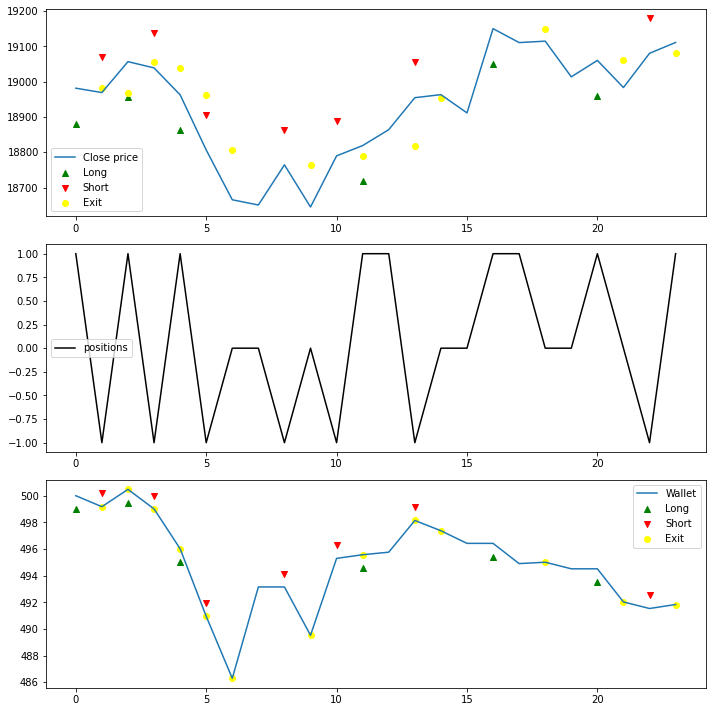

In [755]:
strat.visualize()

### 3. Test performance startegy

In [756]:
l_SharpeRatio = SharpeRatio(profit)
l_MaxDrawback = MaxDrawback(profit)
l_WinLossRatio = WinLossRatio(profit)
l_CumulativeProfit = CumulativeProfit(profit)
l_MeanProfit = MeanProfit(profit)

In [757]:
models = ['Baseline']
metrics = ['SharpeRatio', 'MaxDrawback', 'WinLossRatio', 'CumulativeProfit', 'MeanProfit']
metric_data = [[l_SharpeRatio, l_MaxDrawback, l_WinLossRatio, l_CumulativeProfit, l_MeanProfit]]

pd.DataFrame(metric_data, index=models, columns=metrics)

,SharpeRatio,MaxDrawback,WinLossRatio,CumulativeProfit,MeanProfit
Baseline,-0.125984,-5.067629,0.666667,-8.165326,-0.326613
